# CA County Urban Populations from Zip Classifications

I have a shapefile of California zip codes and a shapefile of California counties. I am given a set of rules that use housing unit density to classify zip codes into rural, urban, or exurban zip codes. The goal is to calculate the proportion of each county's population that lives within each of these zip code classifications.

I demonstrate how to do this below because I think it is an example that makes good use of the overlaying and aggregating features in Pandas/Geopandas and demonstrates how they can be used to answer this question quite easily.

In [2]:
#Import necessary modules
%matplotlib inline
import pandas as pd
import geopandas as gpd
import os
from geopandas.tools import overlay
import shapely

First I read in the zip code shapefile to Geopandas. The GeoDataframe has both population and housing unit counts.

In [3]:
zips=gpd.read_file("Data/Zips.shp").set_index('Zipcode')
zips.geometry=zips.geometry.buffer(0)
zips.head()

,HU,POP,geometry
Zipcode,,,
12,0,0,POLYGON ((-84069.50625625165 251173.9768131553...
16,28,32,POLYGON ((146716.0443333071 -276914.8214906069...
17,56,15,POLYGON ((88071.41057265643 -49057.84702989308...
18,0,0,"POLYGON ((93928.84706553049 -381979.052042436,..."
19,26,36,POLYGON ((-9312.641563633806 307120.0380001596...


I am given the following set of rules to classify zip codes in urban, rural, and suburban zip codes:
- **Urban**: > 1600 housing units per square mile
- **Rural**: < 64 housing units per square mile
- **Exurban**: between 64 and 64 housing units per square mile

I create a series of housing unit densities and then populate a new field called "Class" that categorizes each zip code into one of these categories by querying HU density series. Below, I show that roughly a third of zip codes fall into each of these categories.

In [4]:
#Calculate housing unit density
hu_p_sqmi=zips.HU/(zips.area/2.59e+6)
zips.loc[hu_p_sqmi>1600,'Class']='Urban'
zips.loc[hu_p_sqmi<64,'Class']='Rural'
zips.Class.fillna('Exurban',inplace=True)
zips.Class.value_counts() / len(zips)

Rural      0.366999
Exurban    0.347622
Urban      0.285379
dtype: float64

Then I read in a shapefile of California counties. The next step is to determine for each zip code, which county it is located within. However, this is not super straightforward because of the fact that zip codes are not nested neatly within counties. Therefore, I instead have to determine the 'best-matched' county, which I define as the county that the zip code has the largest portion of its area within. There are a number of other ways that this could be done such as choosing the county that the zip code's centroid is located in (not as accurate), or choosing the county that has the largest portion of its population within (more accurate, but also requiring block level population data). 

In [6]:
counties=gpd.read_file("Data/Counties.shp").set_index('FIPS')[['NAME','geometry']]
counties.geometry=counties.geometry.buffer(0)
counties.head()

,NAME,geometry
FIPS,,
06001,Alameda,(POLYGON ((-170110.5438936652 -30635.387532317...
06003,Alpine,"POLYGON ((8739.968452133704 101531.737647081, ..."
06005,Amador,POLYGON ((-6755.187296495424 77002.27672929561...
06007,Butte,(POLYGON ((-175988.7392603856 205877.926178495...
06009,Calaveras,(POLYGON ((-36381.80589584942 7475.74982997123...


Pursuing my method of matching counties to zip codes based on areal overlap, I use the overlay tools in Geopandas to calculate the intersection between zip codes and counties. I then groupby zip code and county FIPS while summing up the area of each zip / county combination. Then by dividing this by the area of zip codes, I get a series that contains for each zip code, the proportion of its population in each county that it intersects. Most zip codes are pretty close to being entirely located within one county.

In [7]:
zip_x_cnty=overlay(counties.reset_index(),zips.reset_index(),how='intersection')
zip_x_cnty_area=zip_x_cnty.groupby(['Zipcode','FIPS']).apply(lambda x:x.area.sum())/zips.area
zip_x_cnty_area.name='Area'
zip_x_cnty_area.head()

Zipcode  FIPS 
12       06035    0.994684
         06063    0.005316
16       06029    1.000000
17       06019    0.997409
         06027    0.002013
dtype: float64

I then identify the "best-matched" county by grouping by zip code and selecting from each group, the county that has the largest area proportion value. As you can see, at least for the first few zip codes, this matches up with what we would expect to see given the proportions above.

In [16]:
best_county=zip_x_cnty_area.reset_index().groupby('Zipcode').apply(lambda group:group.loc[group.Area.idxmax()])['FIPS']
best_county.head()

Zipcode
12    06035
16    06029
17    06019
18    06111
19    06035
Name: FIPS, dtype: object

Now that we have a 1 county for each zip code, the next step is to determine the proportion of each county's population that falls within each of the 3 zip code categories. I group zip codes by county and by classification, while summing up population. Then by dividing the count in each type by the total, I get the proportion in each type.

In [17]:
county_pop_counts=zips.groupby([best_county,zips.Class])['POP'].sum().unstack().fillna(0)
county_pop_pct=county_pop_counts.div(county_pop_counts.sum(1),axis=0)
county_pop_pct.head()

Class,Exurban,Rural,Urban
FIPS,,,
06001,0.364276,0.032583,0.603141
06003,0.000000,1.000000,0.000000
06005,0.107546,0.892454,0.000000
06007,0.440459,0.391637,0.167903
06009,0.004289,0.995711,0.000000


A quick sort of counties by proportion living in urban zips and by proportion living in rural zips shows about what we would expect: more people are living in urban areas in counties that are located in the Bay Area or the LA Basin; and more people are living in rural areas in counties located in the eastern and northern parts of the state.

In [18]:
county_pop_pct.sort('Urban',ascending=False).reset_index()['FIPS'].map(counties['NAME'])[:5]

0    San Francisco
1           Orange
2      Los Angeles
3        San Mateo
4      Santa Clara
Name: FIPS, dtype: object

In [19]:
county_pop_pct.sort('Rural',ascending=False).reset_index()['FIPS'].map(counties['NAME'])[:5]

0      Siskiyou
1    San Benito
2        Lassen
3         Modoc
4          Mono
Name: FIPS, dtype: object

Lastly, I make a quick plot that symbolizes counties based on their % living in urban zip codes. One surprise, perhaps, is that San Bernadino county (the large county in the southeastern part of the state that contains Joshua Tree and the Mojave Desert) is showing up as having a large urban population. This is because the ovewhelming majority of the population in that county lives in the corder that is right outside Los Angeles. So while the county as a whole is very low density, the average person living in that county does not live in a low density area.

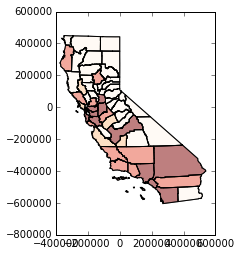

In [20]:
gpd.GeoDataFrame(county_pop_pct, geometry=counties.geometry).plot(column='Urban',scheme='QUANTILES', k=5, colormap='OrRd')